In [133]:
import numpy as np
from skits.preprocessing import HorizonTransformer

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import FeatureUnion

from skits.feature_extraction import AutoregressiveTransformer
from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer
from sklearn.metrics import mean_absolute_error
from azureml.core import Workspace, Dataset

### Add parameters

In [243]:
ws = Workspace.from_config()
ds = Dataset.get_by_name(ws, name='covid-19-measures-cases-weekly')
df = ds.to_pandas_dataframe()

# number of weeks to predict in the future
param_horizon = 10
# number of previous weeks to use as features
param_datapoints_in_past_as_features = 35
param_n_jobs = 16
param_n_estimators = 80

### Define the linear regression pipeline

In [135]:
lin_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=param_horizon)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=param_datapoints_in_past_as_features)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(LinearRegression(fit_intercept=False), n_jobs=param_n_jobs))
])

### Select a subset of data

In [155]:

y = df[df['country']=='Netherlands']['rate_14_day'].values
X = y.reshape(-1, 1).copy()

# TODO move to parameters
test_size = 10
train_size = len(X) - test_size


### Evaluation

In [137]:
lin_pipeline = lin_pipeline.fit(X[:train_size], y[:train_size])
lin_prediction = lin_pipeline.predict(X, start_idx=train_size)

y_actual = lin_pipeline.transform_y(X)
lin_mae = mean_absolute_error(y_actual[-test_size:], lin_prediction, multioutput='raw_values')

forecast = lin_pipeline.forecast(X, start_idx=train_size + 10, trans_window=param_horizon)

### Add the measures as features together with previous y values 

In [213]:
from sklearn.preprocessing import Binarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer

ids = [i for i in range(64)]

tr = ColumnTransformer([
    ('one_hotter', Binarizer(), ids),
    ('ar_features', AutoregressiveTransformer(num_lags=param_datapoints_in_past_as_features),[2])
    ])


### Define the xboost regression pipeline

In [214]:
from xgboost import XGBRegressor

xgb_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=param_horizon)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([('all_features', tr)])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(n_jobs=param_n_jobs, n_estimators=param_n_estimators)))
])

### Evaluation

array([['Netherlands', Timestamp('2020-01-12 00:00:00'), 0.0, ..., False,
        False, False],
       ['Netherlands', Timestamp('2020-01-19 00:00:00'), 0.0, ..., False,
        False, False],
       ['Netherlands', Timestamp('2020-01-26 00:00:00'), 0.0, ..., False,
        False, False],
       ...,
       ['Netherlands', Timestamp('2021-01-17 00:00:00'),
        555.445519174886, ..., False, False, True],
       ['Netherlands', Timestamp('2021-01-24 00:00:00'),
        431.410119207879, ..., False, False, True],
       ['Netherlands', Timestamp('2021-01-31 00:00:00'),
        371.834243202081, ..., False, False, True]], dtype=object)

In [144]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
class Cleaner(BaseEstimator, TransformerMixin):

    needs_refit = True

    def __init__(self, y_only=False):
        super().__init__()
        self.y_only = y_only

    def fit(self, X, y=None):
        mask = pd.isnull(X)
        self._missing_idxs = np.where(mask)
        self._mean = X[~mask].mean()
        return self

    def transform(self, X, y=None, refit=False):
        if refit:
            self.fit(X, y=y)

        check_is_fitted(self, "_mean")
        X[self._missing_idxs] = self._mean
        return X

    def inverse_transform(self, X):
        X[self._missing_idxs] = np.nan
        return X

In [244]:
tr = ColumnTransformer([
    ('ar_features', AutoregressiveTransformer(num_lags=param_datapoints_in_past_as_features),[0]),
    ('one_hotter', Binarizer(), ids),
    ])

In [245]:
xgb_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=param_horizon)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([('all_features', tr)])),
    ('post_feature_imputer', Cleaner()),
    # ('regressor', MultiOutputRegressor(XGBRegressor(n_jobs=param_n_jobs, n_estimators=param_n_estimators)))
    ('regressor', MultiOutputRegressor(LinearRegression(fit_intercept=False)))
])

In [246]:
X = df[df['country']=='Netherlands']
X.drop(['country','week'], axis=1, inplace=True)

In [240]:
xgb_prediction = xgb_pipeline.fit(X.values[:train_size], y[:train_size]).predict(X.values, start_idx=train_size)

y_actual = xgb_pipeline.transform_y(y)
xgb_mae = mean_absolute_error(y_actual[-test_size:], xgb_prediction, multioutput='raw_values')

[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:51] WARNI

In [247]:
xgb_mae

array([135.49450553, 135.58519572, 136.18274739, 151.18991454,
       174.67773922, 178.29885194, 137.45114127, 104.86651963,
       229.40286046, 242.18205188])

Text(0, 0.5, 'Number of cases')

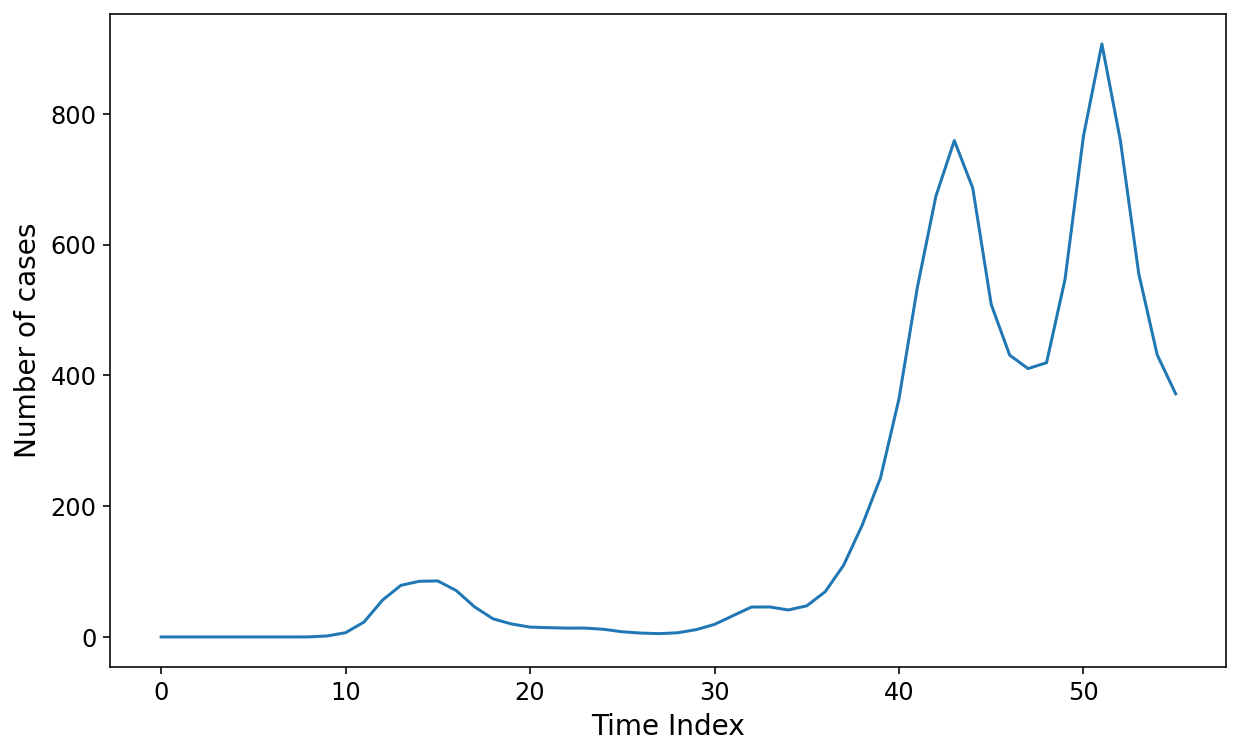

In [234]:
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion()
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
import pickle

plt.plot(y)
plt.xlabel('Time Index')
plt.ylabel('Number of cases')

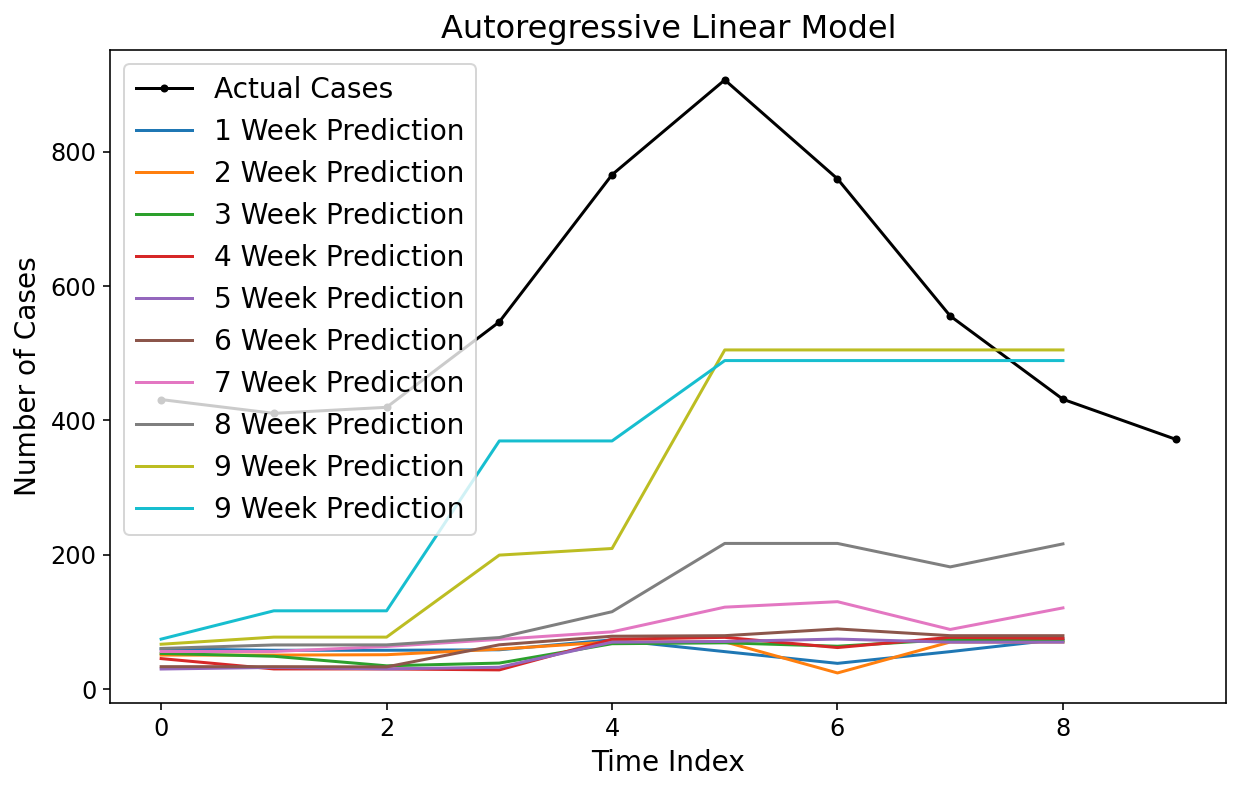

In [248]:
plt.figure();
plt.plot(y[-test_size:], 'k.-')
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 0])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 1])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 2])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 3])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 4])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 5])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 6])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 7])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 8])
plt.plot(np.arange(0, test_size-1), xgb_prediction[:-1, 9])
plt.legend(['Actual Cases',
            '1 Week Prediction',
            '2 Week Prediction',
            '3 Week Prediction',
            '4 Week Prediction',
            '5 Week Prediction',
            '6 Week Prediction',
            '7 Week Prediction',
            '8 Week Prediction',
            '9 Week Prediction',
            '9 Week Prediction'
            ]);
plt.ylabel('Number of Cases');
plt.xlabel('Time Index');
plt.title('Autoregressive Linear Model');

In [235]:
xgb_prediction

array([[67.13948 , 66.972916, 67.1393  , 67.14014 , 67.140236, 67.132805,
        67.13953 , 67.14063 , 67.13207 , 67.10126 ],
       [67.02931 , 66.819855, 67.06616 , 67.06226 , 67.14568 , 67.132805,
        67.08467 , 67.14063 , 67.118744, 67.13875 ],
       [67.02931 , 66.819855, 67.06616 , 67.06226 , 67.14568 , 67.132805,
        67.08467 , 67.14063 , 67.118744, 67.13875 ],
       [67.02931 , 66.819855, 67.06616 , 67.06226 , 67.14568 , 67.132805,
        67.08467 , 67.14063 , 67.118744, 67.13875 ],
       [70.9715  , 68.52004 , 56.938313, 51.17489 , 52.146523, 64.918304,
        63.420734, 53.025414, 31.309418, 34.423325],
       [70.9715  , 68.52004 , 56.938313, 51.17489 , 52.146523, 64.918304,
        63.420734, 53.025414, 31.309418, 34.423325],
       [56.403507, 67.81932 , 62.184273, 50.373993, 63.598465, 67.098366,
        67.69512 , 66.0879  , 58.526047, 28.019789],
       [71.082855, 68.6731  , 57.011448, 51.258617, 52.14203 , 64.918304,
        63.46991 , 53.025414, 31.3227